# Model Evaluation (Training and Validation Loss)

In [11]:
import importlib
import tiktoken
import torch
import torch.nn as nn

In [12]:
with open("the-verdict.txt", "r", encoding = "utf-8") as f:
  rawtext = f.read()

In [13]:
tokenizer = tiktoken.get_encoding("gpt2")

In [14]:
print(rawtext[:100])
totalChars = len(rawtext)
print(totalChars)
totalTokens = len(tokenizer.encode(rawtext))
print(totalTokens)

I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no g
20479
5145


In [15]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length":256, # 1024-->256 (for local pc)
    "emb_dim":768,
    "n_layers":12,
    "n_heads":12,
    "drop_rate":0.1,
    "qkv_bias": False
}

In [16]:
'Layer Normalization'
class LayerNorm(nn.Module):
  def __init__(self, emb_dim):
    super().__init__()
    self.eps = 1e-5
    self.scale = nn.Parameter(torch.ones(emb_dim))
    self.shift = nn.Parameter(torch.zeros(emb_dim))
  def forward(self, x):
    mean = x.mean(dim =-1, keepdim= True) # Mean Along Column
    var = x.var(dim =-1, keepdim= True, unbiased = False) # Variance Along Column
    normalizedX = (x-mean)/torch.sqrt(var+self.eps)  # Eps is small constant to prevent dividing by 0 during normalization
    return self.scale * normalizedX + self.shift

# Scale and shift are two trainable params of same dim as input that LLM automatically adjusts during training and this improves models performance on its training task

'GELU ACTIVATION FUNCTION'
class GELU(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, x):
    return 0.5 * x * (1 + torch.tanh(
        torch.sqrt(torch.tensor(2 / torch.pi)) * (x + 0.044715 * torch.pow(x, 3))
    ))

'Feed Forward Neural Network'
class FeedForward(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(cfg["emb_dim"], 4*cfg["emb_dim"]), #Expansion
        nn.GELU(), # Activation
        nn.Linear(4*cfg["emb_dim"], cfg["emb_dim"]), # Compression
    )

  def forward(self, x):
    return self.layers(x)

In [17]:
'Masked Self Attention'
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

In [18]:
'TRANSFORMER BLOCK'
class TransformerBlock(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.attention = MultiHeadAttention(
        d_in = cfg["emb_dim"],
        d_out = cfg["emb_dim"],
        context_length = cfg["context_length"],
        dropout = cfg["drop_rate"],
        num_heads = cfg["n_heads"],
        qkv_bias= cfg["qkv_bias"]
    )
    self.feedforwardNN = FeedForward(cfg)
    self.normalization1 = LayerNorm(cfg["emb_dim"])
    self.normalization2 = LayerNorm(cfg["emb_dim"])
    self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

  def forward(self, x):
    shortcut = x
    x = self.normalization1(x)
    x = self.attention(x)  #Shape [batch_size, num_tokens, emb_size]
    x = self.drop_shortcut(x)
    x = shortcut + x # Add the original input block

    # Shortcut connection for feed forward block
    shortcut = x
    x = self.normalization2(x)
    x = self.feedforwardNN(x)
    x = self.drop_shortcut(x)
    x = shortcut + x
    return x

In [82]:
class GPTModel(nn.Module):
  def __init__(self, cfg):
    super().__init__()
    self.tokenEmbeddings = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
    self.positionalEmbeddings = nn.Embedding(cfg["context_length"], cfg["emb_dim"]) #(1024x768)
    self.dropuoutEmbeddings = nn.Dropout(cfg["drop_rate"])

    'Transformer Block'
    self.trf_blocks = nn.Sequential(
    *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
   )
    'Layer Normalization'
    self.finalNormalization = LayerNorm(cfg["emb_dim"])
    self.out_head = nn.Linear(
        cfg["emb_dim"],
        cfg["vocab_size"], bias = False
    )

  def forward(self, inIdx):
    batchSize, seqLen  = inIdx.shape
    tokenEmbeddings = self.tokenEmbeddings(inIdx)
    positionalEmbeddings = self.positionalEmbeddings(torch.arange(seqLen, device = inIdx.device))
    x = tokenEmbeddings + positionalEmbeddings
    x = self.dropuoutEmbeddings(x)
    x = self.trf_blocks(x)
    x = self.finalNormalization(x)
    logits = self.out_head(x)
    return logits

In [20]:
def generateText(model, idx, maxNewTokens, contextSize):
    # idx is (batch, numTokens) array of indices in the current context
    for _ in range(maxNewTokens):
        # Crop the current context if it exceeds the supported size
        idxCond = idx[:, -contextSize:]

        # Predictions
        with torch.no_grad():
            logits = model(idxCond)  # (batch, numTokens, vocabSize)

        # S1) Extract last vector
        logits = logits[:, -1, :]  # (batch, vocabSize)

        # S2) Apply softmax to get probabilities
        probs = torch.softmax(logits, dim=-1)

        # S3) Choose the highest probability
        idxNext = torch.argmax(probs, dim=-1, keepdim=True)  # (batch, 1)

        # S4) Append the new token to the sequence
        idx = torch.cat((idx, idxNext), dim=1)  # (batch, numTokens+1)

    return idx


In [21]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length":256, # 1024-->256 (for local pc)
    "emb_dim":768,
    "n_layers":12,
    "n_heads":12,
    "drop_rate":0.1,
    "qkv_bias": False
}
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (tokenEmbeddings): Embedding(50257, 768)
  (positionalEmbeddings): Embedding(256, 768)
  (dropuoutEmbeddings): Dropout(p=0.1, inplace=False)
  (transformerBlock): Sequential(
    (0): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (feedforwardNN): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (normalization1): LayerNorm()
      (normalization2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1)

In [22]:
def textToTokenId(text, tokenizer):
  encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
  encodedTensor = torch.tensor(encoded).unsqueeze(0) # Adding batch dimension
  return encodedTensor
def tokenIdtoText(tokenId, tokenizer):
  flat = tokenId.squeeze(0) # Removing Batch dimension
  return tokenizer.decode(flat.tolist())

startContext = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

tokenIds = generateText(
    model = model,
    idx = textToTokenId(startContext, tokenizer),
    maxNewTokens=10,
    contextSize= GPT_CONFIG_124M["context_length"]
)
print("Output text:\n", tokenIdtoText(tokenIds, tokenizer))


Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


* Dataset and DataLoader

In [23]:
from torch.utils.data import Dataset, DataLoader

class GPTDatasetV1(Dataset):
  def __init__(self, txt, tokenizer, maxLen, stride):
    self.ipIds = []
    self.targetIds = []

    # S1 --> Tokenize the Entire text
    tokenIds = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

    # S2 --> Using sliding window to chunk book into overlapping sequence of maxLen
    for i in range(0, len(tokenIds) - maxLen, stride):
      inputChunk = tokenIds[i:i+maxLen]  # 0->4
      targetChunk = tokenIds[i+1:i+1+maxLen] # 1->5

      self.ipIds.append(torch.tensor(inputChunk))  # Input Tensor X
      self.targetIds.append(torch.tensor(targetChunk)) # Target Tensor Y

  def __len__(self):
    return len(self.ipIds)
  def __getitem__(self, idx):
    return self.ipIds[idx], self.targetIds[idx]  # Ip OP Pairs

In [24]:
def dataLoaderV1(txt, batch_size = 4, max_length = 256,
                 stride = 128, shuffle = True, drop_last = True,
                 num_workers = 0):
  # S1) Initialize the tokenizer
  tokenizer = tiktoken.get_encoding("gpt2")
  # S2) Create Dataset
  dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)
  # S3) Create Dataloader
  dataloader = DataLoader(dataset, batch_size = batch_size,
                          shuffle = shuffle, drop_last = drop_last,
                          num_workers = num_workers)
  return dataloader


* Splitting Dataset

In [25]:
trainRatio = 0.90
splitIdx = int(trainRatio*len(rawtext))
trainingData = rawtext[:splitIdx]
validationData = rawtext[splitIdx:]

torch.manual_seed(123)
trainLoader = dataLoaderV1(
    trainingData,
    batch_size = 2,
    max_length = GPT_CONFIG_124M["context_length"],
    stride = GPT_CONFIG_124M["context_length"],
    shuffle = True,
    drop_last = True,
    num_workers = 0
)

validationLoader = dataLoaderV1(
    validationData,
    batch_size = 2,
    max_length = GPT_CONFIG_124M["context_length"],
    stride = GPT_CONFIG_124M["context_length"],
    drop_last= False,
    shuffle= False,
    num_workers= 0
)

In [26]:
'Sanity Check'
if totalTokens*(trainRatio) < GPT_CONFIG_124M["context_length"]:
  print("Not enough data for training")
if(totalTokens*(1-trainRatio)) < GPT_CONFIG_124M["context_length"]:
  print("Not enough data for validation")

In [27]:
print("Training Loader")
for x, y in trainLoader:
  print(x.shape, y.shape)
print("Validation Loader")
for x, y in validationLoader:
  print(x.shape, y.shape)

Training Loader
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
Validation Loader
torch.Size([2, 256]) torch.Size([2, 256])


In [28]:
trainingTokens = 0
for inputBatch, targetBatch in trainLoader:
  trainingTokens += inputBatch.numel()
validationTokens = 0
for inputBatch, targetBatch in validationLoader:
  validationTokens += inputBatch.numel()
print("Training Tokens: ", trainingTokens)
print("Validation Tokens: ", validationTokens)
print("Total Tokens:", totalTokens)

Training Tokens:  4608
Validation Tokens:  512
Total Tokens: 5145


* Calclating Cross Entropy Loss

In [29]:
def calculateLossBatch(inputBatch, targetBatch, model, device):
  inputBatch, targetBatch = inputBatch.to(device), targetBatch.to(device)
  logits = model(inputBatch)
  loss = torch.nn.functional.cross_entropy(logits.flatten(0,1), targetBatch.flatten(), ignore_index = 0)
  return loss

def calculateLossLoader(dataLoaderV1, model, device, num_batches = None):
  totalLoss = 0
  if(len(dataLoaderV1) == 0): return float("nan")
  elif num_batches is None: num_batches = len(dataLoaderV1)
  else:
    # Reduce the number of batches to match the total no of batches in data loader
    num_batches = min(num_batches, len(dataLoaderV1))
  for i, (inputBatch, targetBatch) in enumerate(dataLoaderV1):
    if i< num_batches:
      loss = calculateLossBatch(inputBatch, targetBatch, model, device)
      totalLoss += loss.item()
    else : break
  return totalLoss/num_batches # Mean Loss per batch

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# NOTE: Connected to T4 GPU on COLAB thats why it is printing CUDA and execution time is less

cuda


In [31]:
model.to(device)

GPTModel(
  (tokenEmbeddings): Embedding(50257, 768)
  (positionalEmbeddings): Embedding(256, 768)
  (dropuoutEmbeddings): Dropout(p=0.1, inplace=False)
  (transformerBlock): Sequential(
    (0): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (feedforwardNN): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (normalization1): LayerNorm()
      (normalization2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1)

In [32]:
torch.manual_seed(123)
with torch.no_grad(): # Disabling gradient tracking for efficiency because we are not training yet
  trainingLoss = calculateLossLoader(trainLoader, model, device)
  validationLoss = calculateLossLoader(validationLoader, model, device)
print("Training Loss: ", trainingLoss)
print("Validation Loss: ", validationLoss)


Training Loss:  10.98753579457601
Validation Loss:  10.983574867248535


# PRETRAINING LOOP (Minimizing Loss)
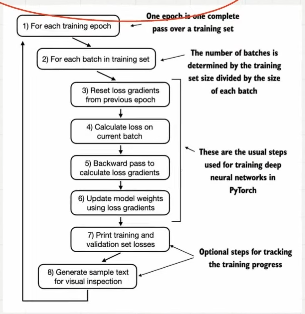

# Training LOOP


In [33]:
def trainModel(model, trainLoader, validationLoader,
               optimizer, device, numOfEpochs, evalFreq, evalIter, startContext, tokenizer):
    trainLosses, validationLosses, trackSeenTokens = [], [], []
    tokensSeen, globalStep = 0, -1

    for epoch in range(numOfEpochs):
        model.train()  # Set Model for training
        for inputBatch, targetBatch in trainLoader:
            optimizer.zero_grad()  # Clear gradients
            loss = calculateLossBatch(inputBatch, targetBatch, model, device)
            loss.backward()  # Calculate loss gradients
            optimizer.step()  # Update model parameters
            tokensSeen += inputBatch.numel()
            globalStep += 1

            # Optional eval step
            if globalStep % evalFreq == 0:
                trainingLoss, validationLoss = evaluateModel(model, trainLoader, validationLoader, evalIter)
                trainLosses.append(trainingLoss)
                validationLosses.append(validationLoss)
                trackSeenTokens.append(tokensSeen)
                print(f"Epoch {epoch+1} (Step {globalStep:06d}): Training Loss: {trainingLoss:.4f}, Validation Loss: {validationLoss:.4f}")

        print(f"Sample Generation After Epoch {epoch+1} :")
        generateAndPrintSample(model, startContext, tokenizer, device)
        print()

    return trainLosses, validationLosses, trackSeenTokens


In [34]:
def evaluateModel(model, trainLoader, validationLoader, evalIter):
  model.eval() # Set model for evaluation
  with torch.no_grad():
    trainingLoss = calculateLossLoader(trainLoader, model, device, num_batches= evalIter)
    validationLoss = calculateLossLoader(validationLoader, model, device, num_batches= evalIter)
  model.train()
  return trainingLoss, validationLoss

In [35]:
def generateAndPrintSample(model, startContext, tokenizer, device):
  model.eval()
  contextSize = model.positionalEmbeddings.weight.shape[0]
  encoded = textToTokenId(startContext, tokenizer).to(device)
  with torch.no_grad():
    tokenIds = generateText(model= model, idx = encoded, maxNewTokens=50,contextSize= contextSize, )
  decodedText = tokenIdtoText(tokenIds, tokenizer)
  print(decodedText.replace("\n", " "))
  model.train()

In [36]:
# Model Training
import time
startingTime = time.time()
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.0004, weight_decay=0.1)
numOfEpochs = 20
trainLosses, validationLosses, tokensSeen = trainModel(
    model,
    trainLoader,
    validationLoader,
    optimizer,
    device,
    numOfEpochs=numOfEpochs,
    evalFreq= 5,
    evalIter= 5,
    startContext= "Every effort moves you",
    tokenizer = tokenizer
)
endingTime = time.time()
totalExecutionTime = (endingTime - startingTime) / 60
print(f"Training completed in {totalExecutionTime: .2f} minutes")

Epoch 1 (Step 000000): Training Loss: 9.8149, Validation Loss: 9.9248
Epoch 1 (Step 000005): Training Loss: 8.0614, Validation Loss: 8.3298
Sample Generation After Epoch 1 :
Every effort moves you,,,,,,,,,,,,.                                     

Epoch 2 (Step 000010): Training Loss: 6.6193, Validation Loss: 7.0485
Epoch 2 (Step 000015): Training Loss: 6.0444, Validation Loss: 6.6025
Sample Generation After Epoch 2 :
Every effort moves you, and,, and,,,,,,, and,.                                   

Epoch 3 (Step 000020): Training Loss: 5.5286, Validation Loss: 6.5063
Epoch 3 (Step 000025): Training Loss: 5.3884, Validation Loss: 6.3860
Sample Generation After Epoch 3 :
Every effort moves you, and to the to the of the to the, and I had. Gis, and, and, and, and, and, and I had the, and, and, and, and, and, and, and, and, and

Epoch 4 (Step 000030): Training Loss: 4.8826, Validation Loss: 6.2777
Epoch 4 (Step 000035): Training Loss: 4.6250, Validation Loss: 6.2945
Sample Generation After

* Validation Loss is much larger than taining loss this indicates model is overfitted  

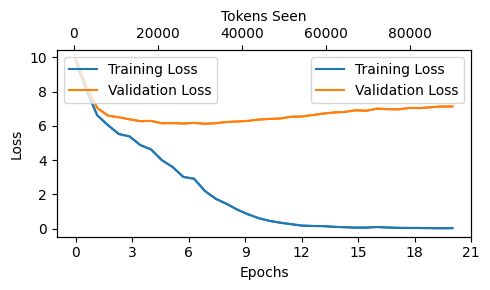

In [37]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
def plotLosses(epochsSeen, tokensSeen, trainLosses, validationLosses):
  fig, ax = plt.subplots(figsize=(5,3))
  ax.plot(epochsSeen, trainLosses, label="Training Loss")
  ax.plot(epochsSeen, validationLosses, label="Validation Loss")
  ax.set_xlabel("Epochs")
  ax.set_ylabel("Loss")
  ax.legend(loc = "upper right")
  ax.xaxis.set_major_locator(MaxNLocator(integer=True)) # only show integer labels


  #Second x axis for tokens seen'
  ax2 = ax.twiny() # shares same y axis
  ax2.plot(tokensSeen, trainLosses, label="Training Loss")
  ax2.plot(tokensSeen, validationLosses, label="Validation Loss")
  ax2.set_xlabel("Tokens Seen")
  ax2.legend(loc = "upper left")

  fig.tight_layout()
  plt.show()

epochsTensor = torch.linspace(0, numOfEpochs, len(trainLosses))
plotLosses(epochsTensor, tokensSeen, trainLosses, validationLosses)


# TECHNIQUES TO CONTROL RANDOMNESS
1) Temperature Scaling
2) Top-K Sampling

In [38]:
model.to("cpu")
model.eval()

GPTModel(
  (tokenEmbeddings): Embedding(50257, 768)
  (positionalEmbeddings): Embedding(256, 768)
  (dropuoutEmbeddings): Dropout(p=0.1, inplace=False)
  (transformerBlock): Sequential(
    (0): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (feedforwardNN): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (normalization1): LayerNorm()
      (normalization2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1)

In [39]:
token_ids = generateText(
    model = model,
    idx = textToTokenId("Every effort moves you", tokenizer),
    maxNewTokens= 25,
    contextSize= GPT_CONFIG_124M["context_length"]
)
print("Output Text:\n", tokenIdtoText(token_ids, tokenizer))

Output Text:
 Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--and by me!"




# DECODING STRATERGY 1: TEMPERATURE SCALING

* Replacing argmax with a function that samples from a probability distribution

In [40]:
sampleVocab = {
    "closer": 0,
    "every": 1,
    "effort": 2,
    "forward": 3,
    "inches": 4,
    "moves": 5,
    "pizza": 6,
    "toward": 7,
    "you":8
}
revrersedVocab = {v:k for k, v in sampleVocab.items()}

In [41]:
nextTokensLogits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

In [42]:
# Previous Method
probs = torch.softmax(nextTokensLogits, dim = 0)
print(probs)
nextTokenId = torch.argmax(probs).item()
print(nextTokenId)
print(revrersedVocab[nextTokenId])

tensor([6.0907e-02, 1.6313e-03, 1.0019e-04, 5.7212e-01, 3.4190e-03, 1.3257e-04,
        1.0120e-04, 3.5758e-01, 4.0122e-03])
3
forward


In [43]:
# New Method
torch.manual_seed(123)
nextTokenId = torch.multinomial(probs, num_samples=1).item()
print(revrersedVocab[nextTokenId])

forward


In [44]:
def printSampledTokens(proobs):
  torch.manual_seed(123)
  sample = [torch.multinomial(probs, num_samples=1).item() for _ in range(1000)]
  sampledIds = torch.bincount(torch.tensor(sample))
  for i, freq in enumerate(sampledIds):
    print(f"{freq} x {revrersedVocab[i]}") # How many times each token is choosen
printSampledTokens(probs)

73 x closer
0 x every
0 x effort
582 x forward
2 x inches
0 x moves
0 x pizza
343 x toward


In [45]:
def softmaxWithTemp(logits, temperature):
  scaledLogits = logits/temperature
  return torch.softmax(scaledLogits, dim = 0)

tempValues = [1, 0.1, 5] # Original, higher confidence, lower confidence
scaledProbs = [softmaxWithTemp(nextTokensLogits, T) for T in tempValues]

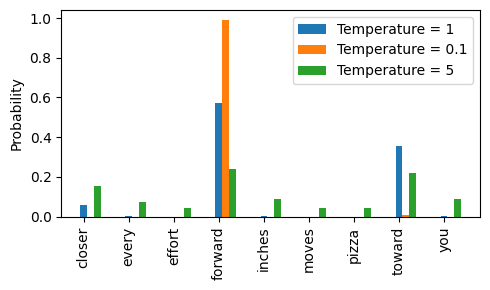

In [46]:
x = torch.arange(len(sampleVocab))
barwidth = 0.15
fig, ax = plt.subplots(figsize=(5,3))
for i, T in enumerate(tempValues):
  rects = ax.bar(x+i*barwidth, scaledProbs[i], barwidth, label = f"Temperature = {T}" )

ax.set_ylabel("Probability")
ax.set_xticks(x)
ax.set_xticklabels(sampleVocab.keys(), rotation = 90)
ax.legend()

plt.tight_layout()
plt.show()

* Too high temp values will lead to more flattened distribution which makes model predict unnecessory token
where as too less temp value will lead to sharp distribution which will cause model to choose a particular word more no of times this concludes TEMP VALUES(T) is a hyperparameter

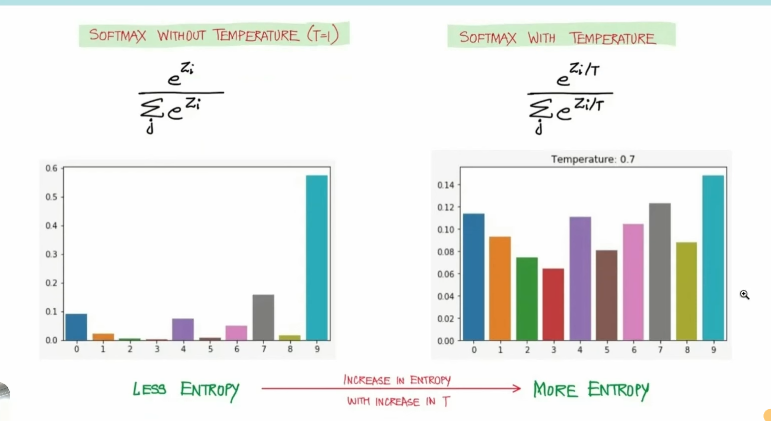

# TECHNIQUE 2: Top-K Sampling
* Used Along Temperature Scaling and it restricts the sampled tokens to the to k most likely tokens and exclude all other tokens


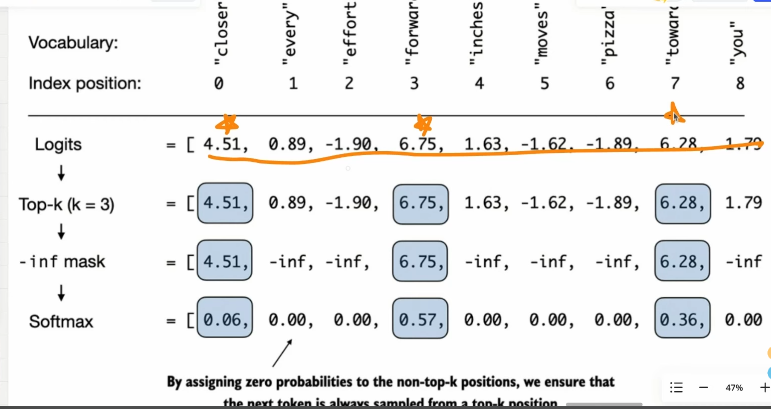

In [47]:
topK = 3
topLogits, topPosis = torch.topk(nextTokensLogits, topK)
print("Top Logits:", topLogits)
print("Top Positions:", topPosis)

Top Logits: tensor([6.7500, 6.2800, 4.5100])
Top Positions: tensor([3, 7, 0])


In [48]:
newLogits = torch.where(
    condition = nextTokensLogits < topLogits[-1],
    input = torch.tensor(float("-inf")),
    other = nextTokensLogits
)
print(newLogits)


tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


* Logits --> TopKsampling --> Logits/Temp --> SoftMax --> Sample from Multinominal Distribution

* This Process Make Sures
1) Next Token prediction is a probablistic process instead of deterministic process
2) Creativity remains intacted
3) Unnecessary tokens are avoides as to be next token

In [49]:
import torch
import torch.nn.functional as F

@torch.no_grad()
def generate(model, idx, maxNewTokens, contextSize, temperature=1.0, topK=None, eosId=None):
    """
    Generate tokens using a model with temperature, top-k filtering, and EOS handling.

    Args:
        model: the language model (must return logits)
        idx: tensor of shape (1, seq_len) with starting token IDs
        maxNewTokens: number of tokens to generate
        contextSize: model context window
        temperature: sampling temperature (default=1.0, lower → deterministic, 0 = greedy)
        topK: if set, sample only from top-K tokens
        eosId: optional end-of-sequence token ID
    """
    for _ in range(maxNewTokens):
        # Crop context to last `contextSize` tokens
        idxCond = idx[:, -contextSize:]

        # Forward pass → logits
        logits = model(idxCond)[:, -1, :]  # shape: (1, vocab_size)

        # Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

        # Top-K filtering
        if topK is not None:
            topLogits, _ = torch.topk(logits, topK)
            minValue = topLogits[:, -1]  # scalar threshold
            logits = torch.where(logits < minValue, torch.tensor(float("-inf"), device=logits.device), logits)

        # Convert logits → probabilities
        probs = F.softmax(logits, dim=-1)

        # Sample next token
        if temperature == 0.0:
            nextId = torch.argmax(probs, dim=-1, keepdim=True)
        else:
            nextId = torch.multinomial(probs, num_samples=1)

        # Append sampled token
        idx = torch.cat((idx, nextId), dim=1)

        # Stop if EOS generated
        if eosId is not None and nextId.item() == eosId:
            break

    return idx


In [50]:
torch.manual_seed(123)
tokenIds = generate(
    model = model,
    idx = textToTokenId("Every effort moves you", tokenizer),
    maxNewTokens=25,
    contextSize= GPT_CONFIG_124M["context_length"],
    topK=25,
    temperature = 1.4
)
print("output text :\n", tokenIdtoText(tokenIds, tokenizer))

output text :
 Every effort moves you?"

"Yes--quite insensible to the portrait. She wanted him vindicated--and by me!"




# SAVING MODEL

In [53]:
# optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay = 0.1)
# torch.save({
#     "model_state_dict": model.state_dict(),
#     "optimizer_state_dict": optimizer.state_dict(),
# }, "modelAndOptimizer.pth")


In [52]:
# model = GPTModel(GPT_CONFIG_124M)
# model.load_state_dict(torch.load("baseGptModel.pth"))
# model.eval()

GPTModel(
  (tokenEmbeddings): Embedding(50257, 768)
  (positionalEmbeddings): Embedding(256, 768)
  (dropuoutEmbeddings): Dropout(p=0.1, inplace=False)
  (transformerBlock): Sequential(
    (0): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (feedforwardNN): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (normalization1): LayerNorm()
      (normalization2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1)

In [54]:
checkpoints = torch.load("modelAndOptimizer.pth")
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoints["model_state_dict"])
optimizer = torch.optim.AdamW(model.parameters(), lr = 5e-4, weight_decay=0.1)
optimizer.load_state_dict(checkpoints["optimizer_state_dict"])
model.train()

GPTModel(
  (tokenEmbeddings): Embedding(50257, 768)
  (positionalEmbeddings): Embedding(256, 768)
  (dropuoutEmbeddings): Dropout(p=0.1, inplace=False)
  (transformerBlock): Sequential(
    (0): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (feedforwardNN): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (normalization1): LayerNorm()
      (normalization2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1)

In [55]:
# from google.colab import files
# files.download("modelAndOptimizer.pth")

# LOADING PRETRAINED OPENAI GPT2 WEIGHTS

In [56]:
! pip install tensorflow>=2.15.0 tqdm>=4.66

In [57]:
import tensorflow as tf
import tqdm
print(tf.__version__)
print(tqdm.__version__)

2.19.0
4.67.1


In [58]:
!pip install --upgrade pip
!pip install tensorflow tqdm requests


In [59]:
from google.colab import files
uploaded = files.upload()  # select gpt_download3.py


Saving gpt_download3.py to gpt_download3 (1).py


In [60]:
import gpt_download3 as gpt_loader

settings, params = gpt_loader.download_and_load_gpt2("124M", "/content/models")


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: /content/models/124M/checkpoint


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: /content/models/124M/encoder.json


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: /content/models/124M/hparams.json
File already exists and is up-to-date: /content/models/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: /content/models/124M/model.ckpt.index


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: /content/models/124M/model.ckpt.meta
File already exists and is up-to-date: /content/models/124M/vocab.bpe


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


In [65]:
print("Settings:", settings)
print("Parameter Dictionary Ket:", params.keys())

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter Dictionary Ket: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


In [62]:
print(params["wpe"])
print(params["g"])

[[-1.8820720e-02 -1.9741860e-01  4.0267250e-03 ... -4.3043736e-02
   2.8267192e-02  5.4490108e-02]
 [ 2.3959434e-02 -5.3792033e-02 -9.4878644e-02 ...  3.4170013e-02
   1.0171850e-02 -1.5572949e-04]
 [ 4.2160717e-03 -8.4763914e-02  5.4514930e-02 ...  1.9744711e-02
   1.9324856e-02 -2.1423856e-02]
 ...
 [-1.7986511e-03  1.6052092e-03 -5.5103153e-02 ...  1.3616630e-02
  -7.1805264e-03  3.7552188e-03]
 [ 3.2105497e-03  1.5500595e-03 -4.8944373e-02 ...  2.0725457e-02
  -1.1837787e-02 -5.5682898e-04]
 [ 2.6609693e-04  3.0272407e-03 -1.7086461e-03 ... -4.6505518e-03
  -2.3541194e-03 -5.7855090e-03]]
[1.3970804e+00 1.3749529e+00 1.8869568e+00 1.1688368e+00 1.2723849e+00
 1.2508119e+00 9.4198198e+00 1.4370559e+00 1.4527462e+00 1.1855773e+00
 1.3945330e+00 1.2796482e+00 1.2070800e+00 1.2951057e+00 1.2775753e+00
 1.3480164e+00 1.5088185e+00 1.3728774e+00 1.3426927e+00 2.3760843e+00
 1.1377202e+00 1.2908599e+00 1.3477147e+00 1.4774984e+00 1.2540178e+00
 1.1998552e+00 1.4932117e+00 1.1637024e+00 1.

In [87]:
modelConfigs = {
    "gpt2-small (124M)": {"emb_dim":768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim":1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim":1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim":1600, "n_layers": 48, "n_heads": 25}
}
modelName = "gpt2-small (124M)"
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(modelConfigs[modelName])
print(NEW_CONFIG)

{'vocab_size': 50257, 'context_length': 256, 'emb_dim': 768, 'n_layers': 12, 'n_heads': 12, 'drop_rate': 0.1, 'qkv_bias': False}


In [88]:
NEW_CONFIG.update({"context_length": 1024, "qkv_bias": True})
gpt = GPTModel(NEW_CONFIG)
gpt.eval()

GPTModel(
  (tokenEmbeddings): Embedding(50257, 768)
  (positionalEmbeddings): Embedding(1024, 768)
  (dropuoutEmbeddings): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (feedforwardNN): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (normalization1): LayerNorm()
      (normalization2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): Transf

In [89]:
def assign(left, right):
  if left.shape != right.shape:
    raise ValueError(f"Shape mismatch, Left: {left.shape}, Right: {right.shape}")
  return torch.nn.Parameter(torch.tensor(right))

# LINKING GPT MODEL WITH PRETRAINED WEIGHTS


In [92]:
def loadWeights(gpt, params):
    gpt.positionalEmbeddings.weight = assign(gpt.positionalEmbeddings.weight, params["wpe"])
    gpt.tokenEmbeddings.weight = assign(gpt.tokenEmbeddings.weight, params["wte"])

    for b in range(len(params["blocks"])):
        # Split Q, K, V weights
        q_w, k_w, v_w = np.split(
            params["blocks"][b]["attn"]["c_attn"]["w"], 3, axis=-1
        )
        gpt.trf_blocks[b].attention.W_query.weight = assign(
            gpt.trf_blocks[b].attention.W_query.weight, q_w.T
        )
        gpt.trf_blocks[b].attention.W_key.weight = assign(
            gpt.trf_blocks[b].attention.W_key.weight, k_w.T
        )
        gpt.trf_blocks[b].attention.W_value.weight = assign(
            gpt.trf_blocks[b].attention.W_value.weight, v_w.T
        )

        # Biases
        q_b, k_b, v_b = np.split(
            params["blocks"][b]["attn"]["c_attn"]["b"], 3, axis=-1
        )
        gpt.trf_blocks[b].attention.W_query.bias = assign(
            gpt.trf_blocks[b].attention.W_query.bias, q_b
        )
        gpt.trf_blocks[b].attention.W_key.bias = assign(
            gpt.trf_blocks[b].attention.W_key.bias, k_b
        )
        gpt.trf_blocks[b].attention.W_value.bias = assign(
            gpt.trf_blocks[b].attention.W_value.bias, v_b
        )

        # Output projection
        gpt.trf_blocks[b].attention.out_proj.weight = assign(
            gpt.trf_blocks[b].attention.out_proj.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T
        )
        gpt.trf_blocks[b].attention.out_proj.bias = assign(
            gpt.trf_blocks[b].attention.out_proj.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"]
        )

        # FeedForward
        gpt.trf_blocks[b].feedforwardNN.layers[0].weight = assign(
            gpt.trf_blocks[b].feedforwardNN.layers[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T
        )
        gpt.trf_blocks[b].feedforwardNN.layers[0].bias = assign(
            gpt.trf_blocks[b].feedforwardNN.layers[0].bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"]
        )
        gpt.trf_blocks[b].feedforwardNN.layers[2].weight = assign(
            gpt.trf_blocks[b].feedforwardNN.layers[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T
        )
        gpt.trf_blocks[b].feedforwardNN.layers[2].bias = assign(
            gpt.trf_blocks[b].feedforwardNN.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"]
        )

        # LayerNorms
        gpt.trf_blocks[b].normalization1.scale = assign(
            gpt.trf_blocks[b].normalization1.scale,
            params["blocks"][b]["ln_1"]["g"]
        )
        gpt.trf_blocks[b].normalization1.shift = assign(
            gpt.trf_blocks[b].normalization1.shift,
            params["blocks"][b]["ln_1"]["b"]
        )
        gpt.trf_blocks[b].normalization2.scale = assign(
            gpt.trf_blocks[b].normalization2.scale,
            params["blocks"][b]["ln_2"]["g"]
        )
        gpt.trf_blocks[b].normalization2.shift = assign(
            gpt.trf_blocks[b].normalization2.shift,
            params["blocks"][b]["ln_2"]["b"]
        )

    # Final LayerNorm and output head
    gpt.finalNormalization.scale = assign(gpt.finalNormalization.scale, params["g"])
    gpt.finalNormalization.shift = assign(gpt.finalNormalization.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])


In [93]:
loadWeights(gpt, params)
gpt.to(device)

GPTModel(
  (tokenEmbeddings): Embedding(50257, 768)
  (positionalEmbeddings): Embedding(1024, 768)
  (dropuoutEmbeddings): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (attention): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (feedforwardNN): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (normalization1): LayerNorm()
      (normalization2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): Transf

In [100]:
device = next(gpt.parameters()).device
idx = textToTokenId("Every effort moves you", tokenizer).to(device)

tokenIds = generate(
    model=gpt,
    idx=idx,
    maxNewTokens=100,
    contextSize=NEW_CONFIG["context_length"],
    topK=50,
    temperature=1.5
)
print("Output Text: \n", tokenIdtoText(tokenIds, tokenizer))


Output Text: 
 Every effort moves you further ahead—and at times—to help a man or the people that deserve to know him, rather than simply moving forward and continuing to look elsewhere.

One example involves a church that has a pastor appointed to their pulpit, but has no congregation (unlike the other groups, its congregants are volunteers doing their "work behind their backs." To some people who care more about other leaders and are concerned more about the quality and quality than about their political power, their leadership makes us
